In [1]:
import pandas as pd
df = pd.read_csv('Scrapper/final.csv', header=None)
df.rename(columns={0: 'comment', 1: 'category'}, inplace=True)

In [2]:
# df.head()
df.category.unique()

array(['positive', 'suggestion', 'question', 'other', 'correction',
       'negative'], dtype=object)

In [3]:
df['category_id'] = df['category'].factorize()[0]
df.head()

,comment,category,category_id
0,Love you sir!!,positive,0
1,Please make videos on..Midpoint circle drawing...,suggestion,1
2,I bought both of your courses on Udemy. You ar...,question,2
3,"Thank you very much, u really got me in the fi...",positive,0
4,i hope u are ok with everything going on again...,other,3


In [4]:
print(df[df.isna().any(axis=1)])

Empty DataFrame
Columns: [comment, category, category_id]
Index: []


In [5]:
# preprocessing

# lowercasing
df['comment'] = df['comment'].str.lower()

# removing urls
df['comment'] = df['comment'].str.replace('http\S+|www.\S+', '', case=False)

# removing commas "\n"
df['comment'] = df['comment'].replace('\n','', regex=True)

# removing all the punctuations
df["comment"] = df['comment'].str.replace('[^\w\s]','')

# removing integers
df['comment'] = df['comment'].replace('\d','', regex=True)
df

,comment,category,category_id
0,love you sir,positive,0
1,please make videos onmidpoint circle drawing a...,suggestion,1
2,i bought both of your courses on udemy you are...,question,2
3,thank you very much u really got me in the fir...,positive,0
4,i hope u are ok with everything going on again...,other,3
...,...,...,...
1033,can i get those ipynb files it will be really...,question,2
1034,brilliant good work,positive,0
1035,nicely explained,positive,0
1036,thank you very informative session,positive,0


In [6]:
# # correcting the typos
# from autocorrect import Speller

# spell = Speller(lang='en')

# def typo_corrector(text):
#     return spell(text)

# df['comment'] = df['comment'].apply(typo_corrector)
# df

In [7]:
# stemming
import nltk

stemmer = nltk.stem.SnowballStemmer('english')
def stem_text(text):
    return stemmer.stem(text)

df['comment'] = df['comment'].apply(stem_text)


# lemmatizing
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return lemmatizer.lemmatize(text)

df['comment'] = df['comment'].apply(lemmatize_text)
df

,comment,category,category_id
0,love you sir,positive,0
1,please make videos onmidpoint circle drawing a...,suggestion,1
2,i bought both of your courses on udemy you are...,question,2
3,thank you very much u really got me in the fir...,positive,0
4,i hope u are ok with everything going on again...,other,3
...,...,...,...
1033,can i get those ipynb files it will be really...,question,2
1034,brilliant good work,positive,0
1035,nicely explained,positive,0
1036,thank you very informative session,positive,0


In [8]:
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)
df.head()

,comment,category,category_id
0,love you sir,positive,0
1,please make videos onmidpoint circle drawing a...,suggestion,1
2,i bought both of your courses on udemy you are...,question,2
3,thank you very much u really got me in the fir...,positive,0
4,i hope u are ok with everything going on again...,other,3


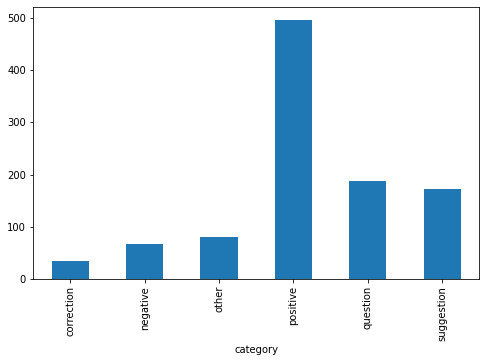

In [9]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,5))
df.groupby('category').comment.count().plot.bar(ylim=0)
plt.show()

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.comment).toarray()
labels = df.category_id
features.shape

(1038, 303)

In [11]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2

for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'correction':
  . Most correlated unigrams:
. pdydx
. wrong
  . Most correlated bigrams:
. great video
. time complexity
# 'negative':
  . Most correlated unigrams:
. fucking
. fuck
  . Most correlated bigrams:
. want learn
. doesnt work
# 'other':
  . Most correlated unigrams:
. hash
. example
  . Most correlated bigrams:
. thank sir
. hash function
# 'positive':
  . Most correlated unigrams:
. best
. thank
  . Most correlated bigrams:
. sir make
. thank sir
# 'question':
  . Most correlated unigrams:
. cost
. using
  . Most correlated bigrams:
. thank sir
. dynamic programming
# 'suggestion':
  . Most correlated unigrams:
. circle
. make
  . Most correlated bigrams:
. make video
. sir make


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['comment'], df['category'], random_state = 0)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [13]:
print(clf.predict(count_vect.transform(["please upload"])))

['suggestion']


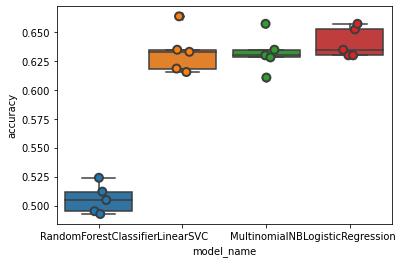

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

cv_df = pd.DataFrame()
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy')
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [15]:
cv_df.index

RangeIndex(start=0, stop=20, step=1)

In [16]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.632934
LogisticRegression        0.640682
MultinomialNB             0.632005
RandomForestClassifier    0.505774
Name: accuracy, dtype: float64

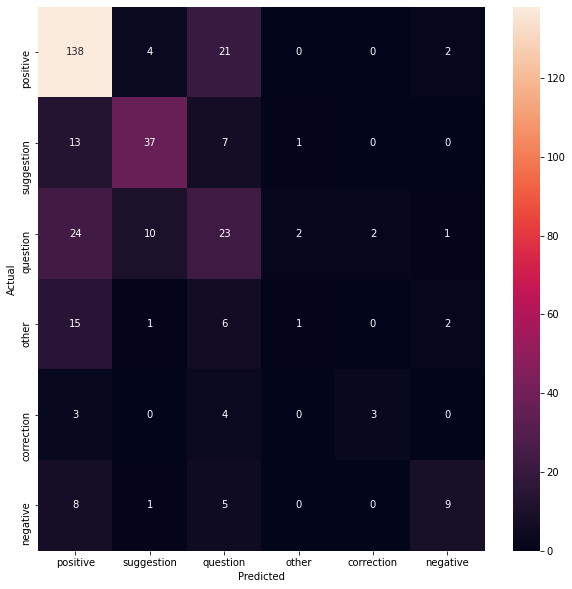

In [17]:
model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [18]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['category', 'comment']])
      print('')

'suggestion' predicted as 'positive' : 13 examples.


,category,comment
826,suggestion,sir please teach these concepts using codei re...
142,suggestion,assalamualaikum teacher may allah give you a g...
935,suggestion,great overview i am now curious to know more a...
239,suggestion,sir please continue on your java series plz si...
175,suggestion,sir could you start teaching python programmin...
776,suggestion,sir lcs problems i think u forget
432,suggestion,mr bari you are a good man i pray you continue...
828,suggestion,excellent explanation sir please explain the i...
54,suggestion,please consider making your previous video pri...
746,suggestion,i love this video please dont ever take it down



'question' predicted as 'positive' : 24 examples.


,category,comment
936,question,indian acc
885,question,sir what are subjects you are teaching your ...
294,question,what is c in d formula
403,question,what if p
316,question,what should i do for line with end points and...
783,question,but and are not connected how are we visitin...
810,question,but sir to find the pattern it will take a lot...
2,question,i bought both of your courses on udemy you are...
196,question,complex
811,question,why t is not being included in this t is also ...



'other' predicted as 'positive' : 15 examples.


,category,comment
672,other,bo for noob
520,other,allah bhala kry is indian bhai jaan kaa inki w...
440,other,april before end gam
970,other,马马虎虎
466,other,but still their is drawback of this funct
202,other,absolute madlad
682,other,illiteracy rate drops to
397,other,example at
439,other,we were this close to achieving greatness
603,other,why is rasgulla in his mouth while teach



'question' predicted as 'suggestion' : 10 examples.


,category,comment
822,question,sir can u upload a video on algorithms of reli...
511,question,anyone know what order to watch these videos h...
787,question,sir bresenhams kab hoga upload
798,question,when are you going to upload the entire cours
30,question,sir can u please explain online algorithms o...
793,question,sir can u made a video bresenham line drawing ...
489,question,sir can you make a video on string matching wi...
366,question,sir asalaamualaikum if pk helps us to decide w...
409,question,int takes bytes of memory so computer has to ...
1008,question,do you as ai makers identify as humans because...



'positive' predicted as 'question' : 21 examples.


,category,comment
447,positive,sir its cool
261,positive,very helpful i had to create a vision check sy...
557,positive,donate to his patreon page guysi just did even...
506,positive,i have learned so much from you cant thank you...
495,positive,hello sir i am one of ur student from vani
303,positive,sir why dont u come to our clg sir u r jst grt
101,positive,getting u as a teacheris matter of fortune for...
620,positive,tq sir
979,positive,currently doing my final year project which in...
764,positive,the main issue why for some word users this le...


In [19]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['category'].unique()))

              precision    recall  f1-score   support

    positive       0.69      0.84      0.75       165
  suggestion       0.70      0.64      0.67        58
    question       0.35      0.37      0.36        62
       other       0.25      0.04      0.07        25
  correction       0.60      0.30      0.40        10
    negative       0.64      0.39      0.49        23

    accuracy                           0.62       343
   macro avg       0.54      0.43      0.46       343
weighted avg       0.59      0.62      0.59       343

